In [1]:
import tensorflow as tf
from fairlearn.metrics import MetricFrame, selection_rate
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import diffprivlib.models as dp
import shap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
n_samples = 1000
y_true = np.random.randint(0, 2, n_samples)  # 0 = unhealthy, 1 = healthy (mock labels)
y_pred = y_true.copy()
y_pred[:200] = 1 - y_pred[:200]  # introduce some prediction errors

# Create a sensitive attribute (e.g., gender)
gender = np.random.choice(['male', 'female'], size=n_samples)

data = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred,
    'gender': gender
})

data.head()

,y_true,y_pred,gender
0,0,1,female
1,1,0,male
2,0,1,male
3,0,1,male
4,0,1,male


In [3]:
metric = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "selection_rate": selection_rate
    },
    y_true=data["y_true"],
    y_pred=data["y_pred"],
    sensitive_features=data["gender"]
)

print("Fairness metrics by gender:\n")
print(metric.by_group)

print("\nOverall metrics:\n")
print(metric.overall)

Fairness metrics by gender:

        accuracy  selection_rate
gender                          
female  0.812236        0.497890
male    0.788973        0.520913

Overall metrics:

accuracy          0.80
selection_rate    0.51
dtype: float64


In [4]:
import sklearn
import numpy as np
from sklearn.base import BaseEstimator

# Patch sklearn to add missing _validate_data if not found (for diffprivlib compatibility)
if not hasattr(BaseEstimator, "_validate_data"):
    from sklearn.utils.validation import check_array, check_X_y
    def _validate_data(self, X, y=None, reset=True, **kwargs):
        if y is None:
            return check_array(X, **kwargs)
        else:
            return check_X_y(X, y, **kwargs)
    BaseEstimator._validate_data = _validate_data

    
from diffprivlib.models import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Create a small synthetic dataset
X, y = make_classification(n_samples=1000, n_features=5, random_state=42)
X = StandardScaler().fit_transform(X)

# Train differentially private logistic regression
dp_model = LogisticRegression(epsilon=1.0)
dp_model.fit(X, y)

print("Differentially Private Logistic Regression trained successfully!")
print("Accuracy:", dp_model.score(X, y))

Differentially Private Logistic Regression trained successfully!
Accuracy: 0.618


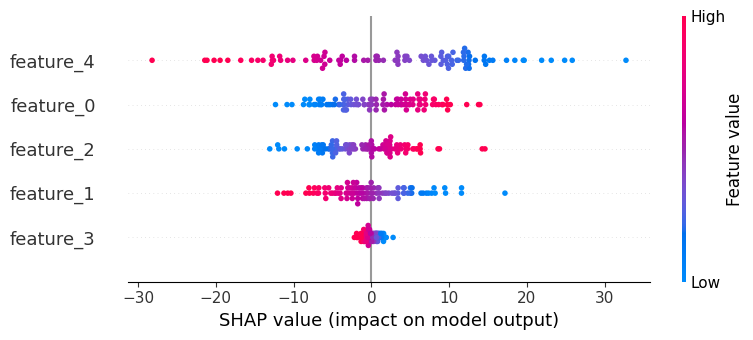

In [5]:
explainer = shap.Explainer(dp_model, X)
shap_values = explainer(X[:100])

shap.summary_plot(shap_values, X[:100], feature_names=[f"feature_{i}" for i in range(X.shape[1])])

In [9]:
import numpy as np
import pandas as pd

# Simulated predictions for demonstration
y_pred_ref = np.random.binomial(1, 0.6, size=500)
y_pred_prod = np.random.binomial(1, 0.4, size=500)

# Simple drift check using KL Divergence (manual)
from scipy.stats import entropy

p_ref = np.bincount(y_pred_ref, minlength=2) / len(y_pred_ref)
p_prod = np.bincount(y_pred_prod, minlength=2) / len(y_pred_prod)

kl_divergence = entropy(p_ref, p_prod)
print(f"KL Divergence (proxy for drift): {kl_divergence:.4f}")

KL Divergence (proxy for drift): 0.1180
